# Mariners 2026 Data Science Intern Problem Set
## Outfielder 6HuoaRi0 Performance Analysis Report

**Author:** Caleb Lee  
**Organization:** Seattle Mariners  


## Executive Summary

This analysis evaluates outfielder 6HuoaRi0's defensive performance in sacrifice play situations, focusing on his ability to prevent runner advancement. The analysis uses contextual baselines to account for game situation factors and provides actionable insights for coaching staff.


## Problem Statement

Outfielder 6HuoaRi0 has just been called up from Triple-A and the Major League coaching staff would like to know how effective he is at preventing runners from advancing on sacrifice plays, believing this could be a way for him to separate himself and earn more playing time. Using the data provided, prepare a 1-2 page report for a coaching staff audience to answer their query. Please supply any code used to generate this report.



## Data Loading and Initial Setup

This section loads the training data, test data, and outfielder positioning data, then provides an initial overview of the datasets.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


In [ ]:
# Load the datasets
print("Loading data for outfielder analysis...")
train_df = pd.read_csv('../Data/train_data.csv')
test_df = pd.read_csv('../Data/test_data.csv')
outfield_df = pd.read_csv('../Data/outfield_position.csv')

target_fielder = '6HuoaRi0'

print(f"Training data: {len(train_df)} plays")
print(f"Test data: {len(test_df)} plays")
print(f"Outfield positioning data: {len(outfield_df)} measurements")
print(f"Target outfielder: {target_fielder}")

# Check if target fielder exists in data
fielder_in_train = target_fielder in train_df['fielder_id'].values
fielder_in_test = target_fielder in test_df['fielder_id'].values
fielder_in_outfield = target_fielder in outfield_df['player_id'].values

print(f"\nFielder presence:")
print(f"  - Training data: {fielder_in_train}")
print(f"  - Test data: {fielder_in_test}")
print(f"  - Positioning data: {fielder_in_outfield}")


Loading data for outfielder analysis...
Training data: 15533 plays
Test data: 2684 plays
Outfield positioning data: 62574 measurements
Target outfielder: 6HuoaRi0

Fielder presence:
  - Training data: True
  - Test data: True
  - Positioning data: True


## Performance Analysis

This section analyzes the outfielder's basic performance metrics and converts the analysis to a prevention frame (coaches think "Did he hold the runner?").


=== ANALYZING OUTFIELDER 6HuoaRi0 ===
Plays in training data: 63
Plays in test data: 12

=== PERFORMANCE SUMMARY ===
Total plays: 63
Prevented advances: 30
Allowed advances: 33
Prevention rate: 0.476


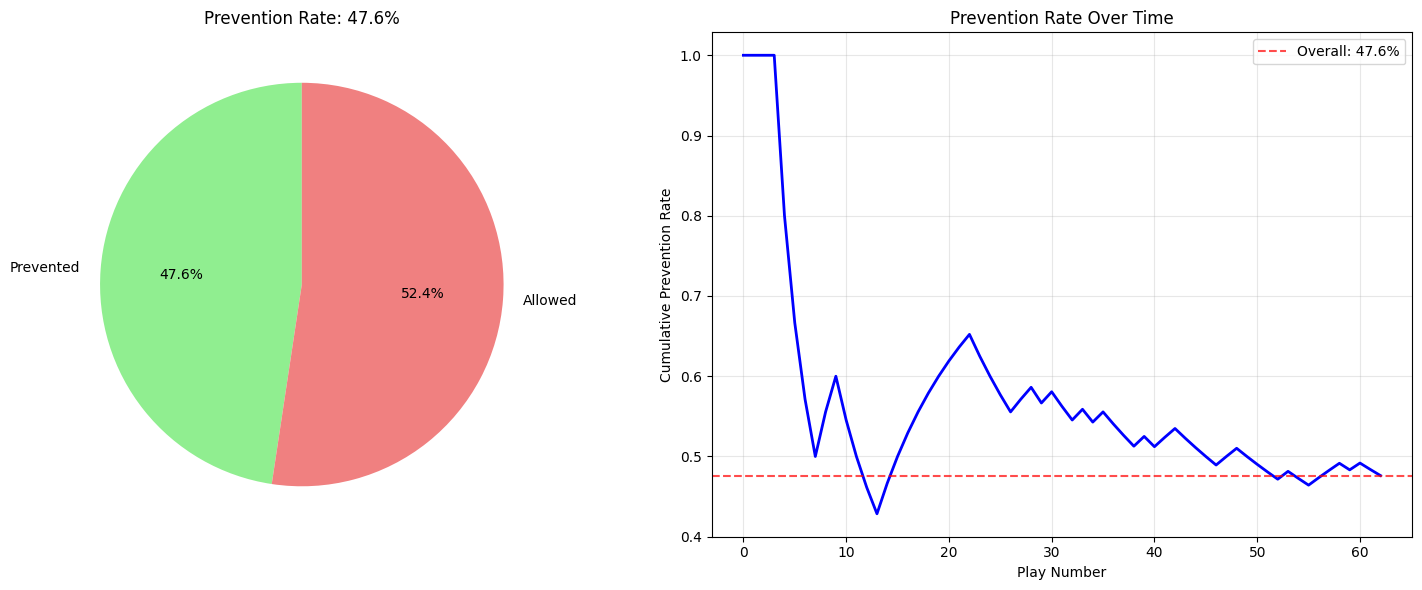

In [3]:
# Get fielder's plays from train data
fielder_train = train_df[train_df['fielder_id'] == target_fielder].copy()
fielder_test = test_df[test_df['fielder_id'] == target_fielder].copy()

print(f"=== ANALYZING OUTFIELDER {target_fielder} ===")
print(f"Plays in training data: {len(fielder_train)}")
print(f"Plays in test data: {len(fielder_test)}")

if len(fielder_train) == 0:
    print(f"Error: {target_fielder} not found in training data")
else:
    # Convert to prevention frame (coaches think "Did he hold the runner?")
    fielder_train['prevented'] = 1 - fielder_train['runner_advance']
    
    # Basic performance metrics
    prevention_rate = fielder_train['prevented'].mean()
    total_plays = len(fielder_train)
    prevented_advances = fielder_train['prevented'].sum()
    allowed_advances = total_plays - prevented_advances
    
    print(f"\n=== PERFORMANCE SUMMARY ===")
    print(f"Total plays: {total_plays}")
    print(f"Prevented advances: {prevented_advances}")
    print(f"Allowed advances: {allowed_advances}")
    print(f"Prevention rate: {prevention_rate:.3f}")
    
    # Create visualization of prevention rate
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Prevention rate pie chart
    labels = ['Prevented', 'Allowed']
    sizes = [prevented_advances, allowed_advances]
    colors = ['lightgreen', 'lightcoral']
    
    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax1.set_title(f'Prevention Rate: {prevention_rate:.1%}')
    
    # Prevention rate over time (if we have game order)
    if 'game_id' in fielder_train.columns:
        # Create a simple time series of prevention rate
        fielder_train_sorted = fielder_train.sort_values('game_id')
        cumulative_prevention = fielder_train_sorted['prevented'].expanding().mean()
        
        ax2.plot(range(len(cumulative_prevention)), cumulative_prevention, 'b-', linewidth=2)
        ax2.axhline(y=prevention_rate, color='r', linestyle='--', alpha=0.7, label=f'Overall: {prevention_rate:.1%}')
        ax2.set_xlabel('Play Number')
        ax2.set_ylabel('Cumulative Prevention Rate')
        ax2.set_title('Prevention Rate Over Time')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        # If no time data, show distribution of prevention rates by position
        if 'fielder_pos' in fielder_train.columns:
            pos_prevention = fielder_train.groupby('fielder_pos')['prevented'].mean()
            pos_prevention.plot(kind='bar', ax=ax2, color='steelblue')
            ax2.set_title('Prevention Rate by Position')
            ax2.set_ylabel('Prevention Rate')
            ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


## Contextual Analysis

This section performs contextual baseline analysis to compare the outfielder's performance against league averages in similar game situations.


In [4]:
def wilson_ci(p, n, z=1.96):
    """Calculate Wilson confidence interval for prevention rate (handles small n)"""
    if n == 0: 
        return (np.nan, np.nan)
    denom = 1 + z*z/n
    center = (p + z*z/(2*n)) / denom
    half = (z * sqrt(p*(1-p)/n + z*z/(4*n*n))) / denom
    return center - half, center + half

# Contextual baseline analysis
print(f"\n=== CONTEXTUAL BASELINE ANALYSIS ===")

# Make depth_bin for the entire train first (same cut everywhere)
bins = [0, 250, 350, np.inf]
labels = ['shallow', 'medium', 'deep']
train_df['depth_bin'] = pd.cut(train_df['hit_distance'], bins=bins, labels=labels)

# Player frame with prevention
fielder_train = train_df[train_df['fielder_id'] == target_fielder].copy()
fielder_train['prevented'] = 1 - fielder_train['runner_advance']

# League (exclude player rows to avoid circularity)
league_df = train_df[train_df['fielder_id'] != target_fielder].copy()
league_df['prevented'] = 1 - league_df['runner_advance']

ctx_cols = ['runner_base', 'outs', 'depth_bin']

# Player stats by context
ply = (fielder_train.groupby(ctx_cols, observed=True)['prevented']
       .agg(['mean', 'count']).reset_index()
       .rename(columns={'mean': 'player_prevent', 'count': 'n'}))

# League baseline by context
base = (league_df.groupby(ctx_cols, observed=True)['prevented']
        .mean().rename('league_prevent').reset_index())

tbl = ply.merge(base, on=ctx_cols, how='left')
tbl['diff'] = tbl['player_prevent'] - tbl['league_prevent']

# Calculate Wilson CI for each row
tbl[['ci_low', 'ci_high']] = tbl.apply(
    lambda r: pd.Series(wilson_ci(r['player_prevent'], r['n'])), axis=1
)

# Calculate runs prevented vs baseline
run_value = {2: 0.25, 3: 0.80}
tbl['run_value'] = tbl['runner_base'].map(run_value).fillna(0.25)
tbl['runs_prevented'] = tbl['diff'] * tbl['n'] * tbl['run_value']
total_rp = tbl['runs_prevented'].sum()

# Calculate impact for sorting
tbl['impact'] = tbl['diff'].abs() * tbl['n'] * tbl['run_value']

print(f"Estimated runs prevented vs context: {total_rp:.2f} (over {len(fielder_train)} opportunities in this sample)")

# Create coach table for export
coach = tbl.copy()
coach['context'] = (
    'Base' + coach['runner_base'].astype(str) +
    '_Outs' + coach['outs'].astype(str) +
    '_' + coach['depth_bin'].astype(str)
)
coach_display = (coach
    .loc[:, ['context','n','player_prevent','league_prevent','diff','ci_low','ci_high','runs_prevented','impact']]
    .sort_values('impact', ascending=False)
)
coach_display.to_csv(f'{target_fielder}_context_table.csv', index=False)
print(f"Coach table exported to: {target_fielder}_context_table.csv")



=== CONTEXTUAL BASELINE ANALYSIS ===
Estimated runs prevented vs context: 3.05 (over 63 opportunities in this sample)
Coach table exported to: 6HuoaRi0_context_table.csv



=== HEADLINE CONTEXTS (n ≥ 10) ===
Base3_Outs1_medium: 0.357 vs 0.121 (diff: +0.236, n=14, CI: [0.163, 0.612], impact: 2.65)
Base2_Outs1_medium: 0.765 vs 0.742 (diff: +0.023, n=17, CI: [0.527, 0.904], impact: 0.10)

=== ALL CONTEXTS (APPENDIX) ===
Base3_Outs1_medium: 0.357 vs 0.121 (diff: +0.236, n=14, CI: [0.163, 0.612])
Base3_Outs0_medium: 0.500 vs 0.126 (diff: +0.374, n=2, CI: [0.095, 0.905])
  → Directional only (n=2)
Base2_Outs0_medium: 0.500 vs 0.631 (diff: -0.131, n=8, CI: [0.215, 0.785])
  → Directional only (n=8)
Base2_Outs1_deep: 0.200 vs 0.322 (diff: -0.122, n=5, CI: [0.036, 0.624])
  → Directional only (n=5)
Base3_Outs1_shallow: 1.000 vs 0.817 (diff: +0.183, n=1, CI: [0.207, 1.000])
  → Directional only (n=1)
Base2_Outs1_medium: 0.765 vs 0.742 (diff: +0.023, n=17, CI: [0.527, 0.904])
Base2_Outs0_deep: 0.000 vs 0.103 (diff: -0.103, n=3, CI: [0.000, 0.562])
  → Directional only (n=3)
Base2_Outs1_shallow: 1.000 vs 0.930 (diff: +0.070, n=4, CI: [0.510, 1.000])
  → Directional 

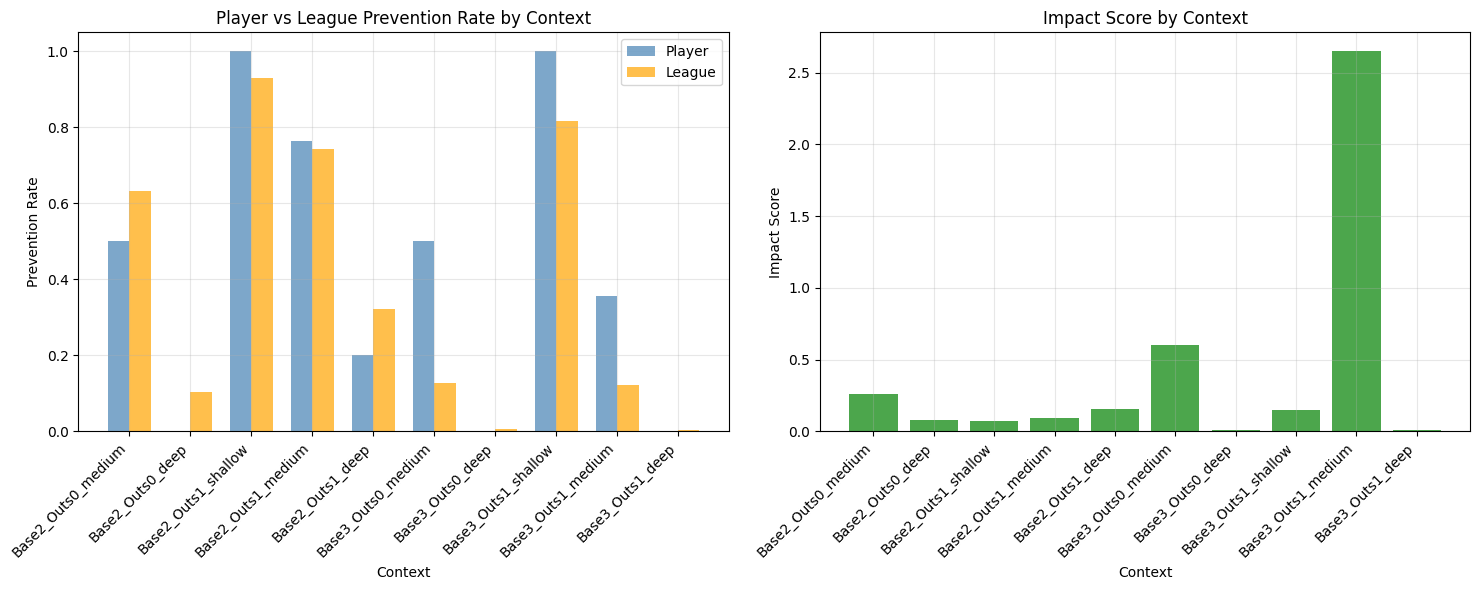

In [5]:
# Display contextual performance
print("\n=== HEADLINE CONTEXTS (n ≥ 10) ===")
headline_contexts = tbl[tbl['n'] >= 10].sort_values('impact', ascending=False)
if len(headline_contexts) > 0:
    for _, row in headline_contexts.iterrows():
        context = f"Base{row['runner_base']}_Outs{row['outs']}_{row['depth_bin']}"
        print(f"{context}: {row['player_prevent']:.3f} vs {row['league_prevent']:.3f} "
              f"(diff: {row['diff']:+.3f}, n={row['n']}, "
              f"CI: [{row['ci_low']:.3f}, {row['ci_high']:.3f}], impact: {row['impact']:.2f})")
else:
    print("No contexts with n ≥ 10")

print("\n=== ALL CONTEXTS (APPENDIX) ===")
for _, row in tbl.sort_values('impact', ascending=False).iterrows():
    context = f"Base{row['runner_base']}_Outs{row['outs']}_{row['depth_bin']}"
    print(f"{context}: {row['player_prevent']:.3f} vs {row['league_prevent']:.3f} "
          f"(diff: {row['diff']:+.3f}, n={row['n']}, "
          f"CI: [{row['ci_low']:.3f}, {row['ci_high']:.3f}])")
    
    # Flag small samples
    if row['n'] < 10:
        print(f"  → Directional only (n={row['n']})")

# Create visualization of contextual performance
if len(tbl) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Context performance comparison
    contexts = [f"Base{row['runner_base']}_Outs{row['outs']}_{row['depth_bin']}" for _, row in tbl.iterrows()]
    player_rates = tbl['player_prevent'].values
    league_rates = tbl['league_prevent'].values
    
    x = np.arange(len(contexts))
    width = 0.35
    
    ax1.bar(x - width/2, player_rates, width, label='Player', color='steelblue', alpha=0.7)
    ax1.bar(x + width/2, league_rates, width, label='League', color='orange', alpha=0.7)
    
    ax1.set_xlabel('Context')
    ax1.set_ylabel('Prevention Rate')
    ax1.set_title('Player vs League Prevention Rate by Context')
    ax1.set_xticks(x)
    ax1.set_xticklabels(contexts, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Impact analysis
    ax2.bar(range(len(tbl)), tbl['impact'].values, color='green', alpha=0.7)
    ax2.set_xlabel('Context')
    ax2.set_ylabel('Impact Score')
    ax2.set_title('Impact Score by Context')
    ax2.set_xticks(range(len(tbl)))
    ax2.set_xticklabels(contexts, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## Positioning Analysis

This section analyzes the outfielder's positioning data and physical attributes including throw speed analysis.



=== POSITIONING ANALYSIS ===
Positioning data points: 224

Average positioning by event:
                   pos_x          pos_y       
                    mean    std    mean    std
event_description                             
Ball was caught    19.71  77.77  292.16  44.28
Ball was hit       18.53  64.90  302.96  29.15

Average distance from center: 308.2 feet


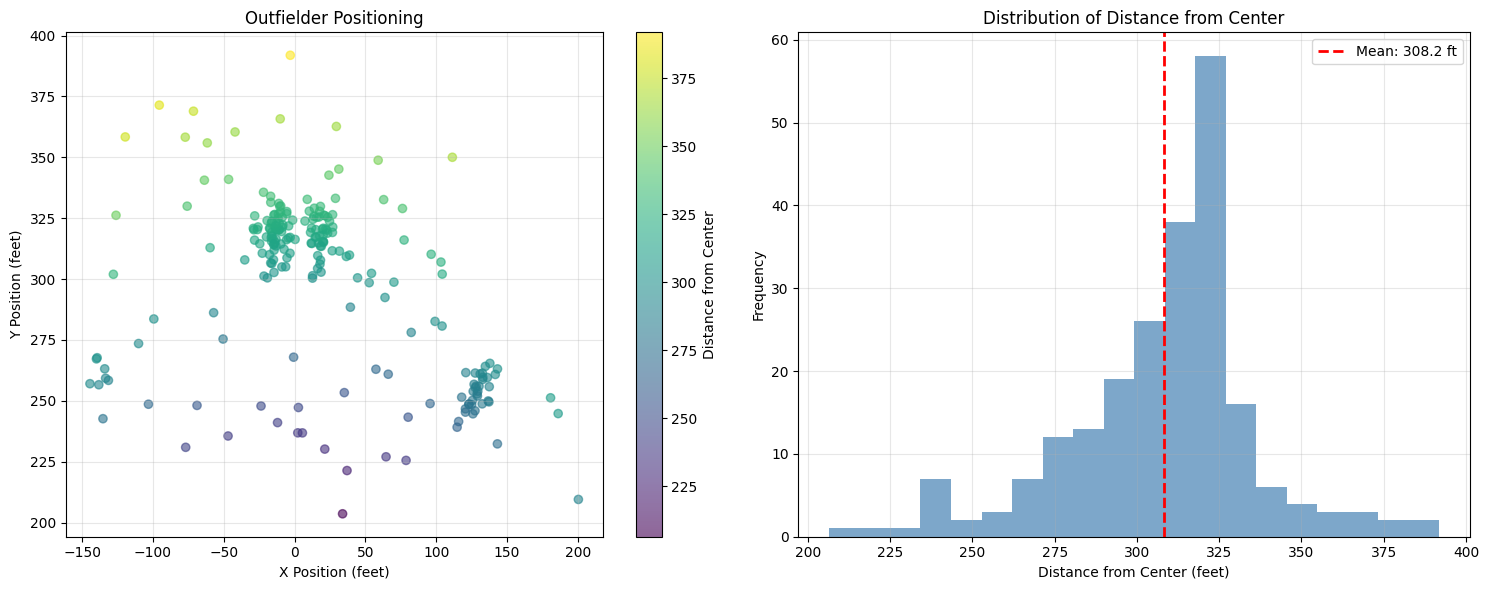

In [6]:
# Analyze outfielder's positioning data
print(f"\n=== POSITIONING ANALYSIS ===")

# Get outfielder's positioning data
fielder_positions = outfield_df[
    outfield_df['player_id'] == target_fielder
].copy()

if len(fielder_positions) == 0:
    print("No positioning data available for this outfielder")
    positioning_analysis = None
else:
    print(f"Positioning data points: {len(fielder_positions)}")
    
    # Analyze positioning by event
    position_by_event = fielder_positions.groupby('event_description').agg({
        'pos_x': ['mean', 'std'],
        'pos_y': ['mean', 'std']
    }).round(2)
    
    print("\nAverage positioning by event:")
    print(position_by_event)
    
    # Calculate average distance from center
    fielder_positions['distance_from_center'] = np.sqrt(
        fielder_positions['pos_x']**2 + fielder_positions['pos_y']**2
    )
    
    avg_distance = fielder_positions['distance_from_center'].mean()
    print(f"\nAverage distance from center: {avg_distance:.1f} feet")
    
    # Create positioning visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Position scatter plot
    scatter = ax1.scatter(fielder_positions['pos_x'], fielder_positions['pos_y'], 
                        c=fielder_positions['distance_from_center'], cmap='viridis', alpha=0.6)
    ax1.set_xlabel('X Position (feet)')
    ax1.set_ylabel('Y Position (feet)')
    ax1.set_title('Outfielder Positioning')
    ax1.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax1, label='Distance from Center')
    
    # Distance distribution
    ax2.hist(fielder_positions['distance_from_center'], bins=20, alpha=0.7, color='steelblue')
    ax2.axvline(avg_distance, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_distance:.1f} ft')
    ax2.set_xlabel('Distance from Center (feet)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Distance from Center')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    positioning_analysis = fielder_positions



=== PHYSICAL ATTRIBUTES ===
Throw speed analysis: {'mean': np.float64(100.6285714285714), 'median': np.float64(101.2), 'winsorized_mean': np.float64(100.6285714285714), 'winsorized_median': np.float64(101.2), 'p95': np.float64(101.2), 'outliers_removed': np.int64(0), 'league_percentile': np.float64(0.9626680939318927)}


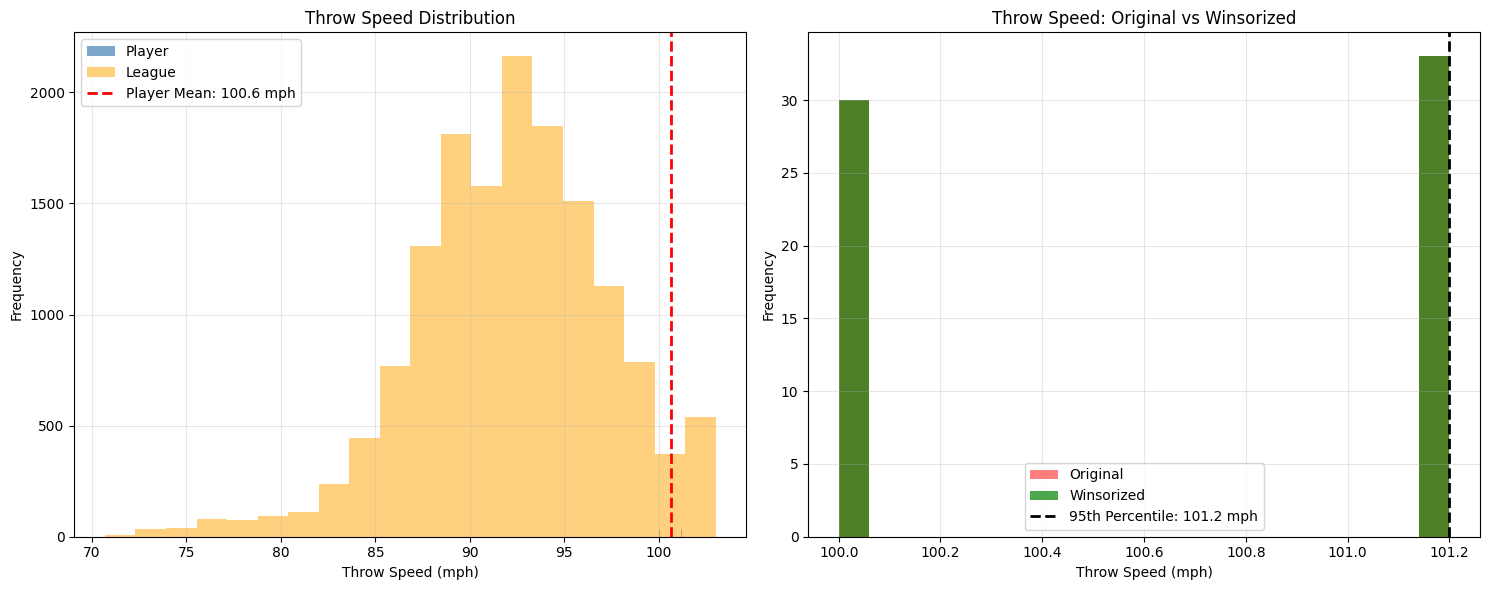

In [7]:
# Physical attributes analysis with outlier handling
print(f"\n=== PHYSICAL ATTRIBUTES ===")

def analyze_throw_speed(fielder_data, league_df):
    """Analyze throw speed with outlier handling and percentile ranking"""
    throw_speeds = fielder_data['fielder_max_throwspeed'].dropna()
    league_throws = league_df['fielder_max_throwspeed'].dropna()
    
    if len(throw_speeds) == 0:
        return "No throw speed data available"
    
    # Winsorize outliers (cap at 95th percentile)
    p95 = throw_speeds.quantile(0.95)
    winsorized = np.where(throw_speeds > p95, p95, throw_speeds)
    
    # Calculate percentile in league
    player_median = throw_speeds.median()
    league_percentile = (league_throws < player_median).mean()
    
    analysis = {
        'mean': throw_speeds.mean(),
        'median': throw_speeds.median(),
        'winsorized_mean': winsorized.mean(),
        'winsorized_median': np.median(winsorized),
        'p95': p95,
        'outliers_removed': (throw_speeds > p95).sum(),
        'league_percentile': league_percentile
    }
    
    return analysis

# Analyze throw speed
throw_analysis = analyze_throw_speed(fielder_train, league_df)
print(f"Throw speed analysis: {throw_analysis}")

# Create throw speed visualization if data is available
if isinstance(throw_analysis, dict) and 'mean' in throw_analysis:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Throw speed distribution
    throw_speeds = fielder_train['fielder_max_throwspeed'].dropna()
    league_throws = league_df['fielder_max_throwspeed'].dropna()
    
    ax1.hist(throw_speeds, bins=20, alpha=0.7, color='steelblue', label='Player')
    ax1.hist(league_throws, bins=20, alpha=0.5, color='orange', label='League')
    ax1.axvline(throw_analysis['mean'], color='red', linestyle='--', linewidth=2, label=f"Player Mean: {throw_analysis['mean']:.1f} mph")
    ax1.set_xlabel('Throw Speed (mph)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Throw Speed Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Winsorized comparison
    p95 = throw_speeds.quantile(0.95)
    winsorized = np.where(throw_speeds > p95, p95, throw_speeds)
    
    ax2.hist(throw_speeds, bins=20, alpha=0.5, color='red', label='Original')
    ax2.hist(winsorized, bins=20, alpha=0.7, color='green', label='Winsorized')
    ax2.axvline(p95, color='black', linestyle='--', linewidth=2, label=f'95th Percentile: {p95:.1f} mph')
    ax2.set_xlabel('Throw Speed (mph)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Throw Speed: Original vs Winsorized')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## Performance by Position and Hit Type

This section analyzes the outfielder's performance breakdown by position and hit trajectory.



=== PERFORMANCE BY POSITION ===
Prevention Rate by Position:
            prevented           runner_advance
                count sum  mean           mean
fielder_pos                                   
CF                 51  26  0.51           0.49
LF                  2   1  0.50           0.50
RF                 10   3  0.30           0.70

=== PERFORMANCE BY HIT TYPE ===
Prevention Rate by Hit Type:
               prevented            runner_advance
                   count sum   mean           mean
hit_trajectory                                    
fly_ball              52  23  0.442          0.558
line_drive            11   7  0.636          0.364


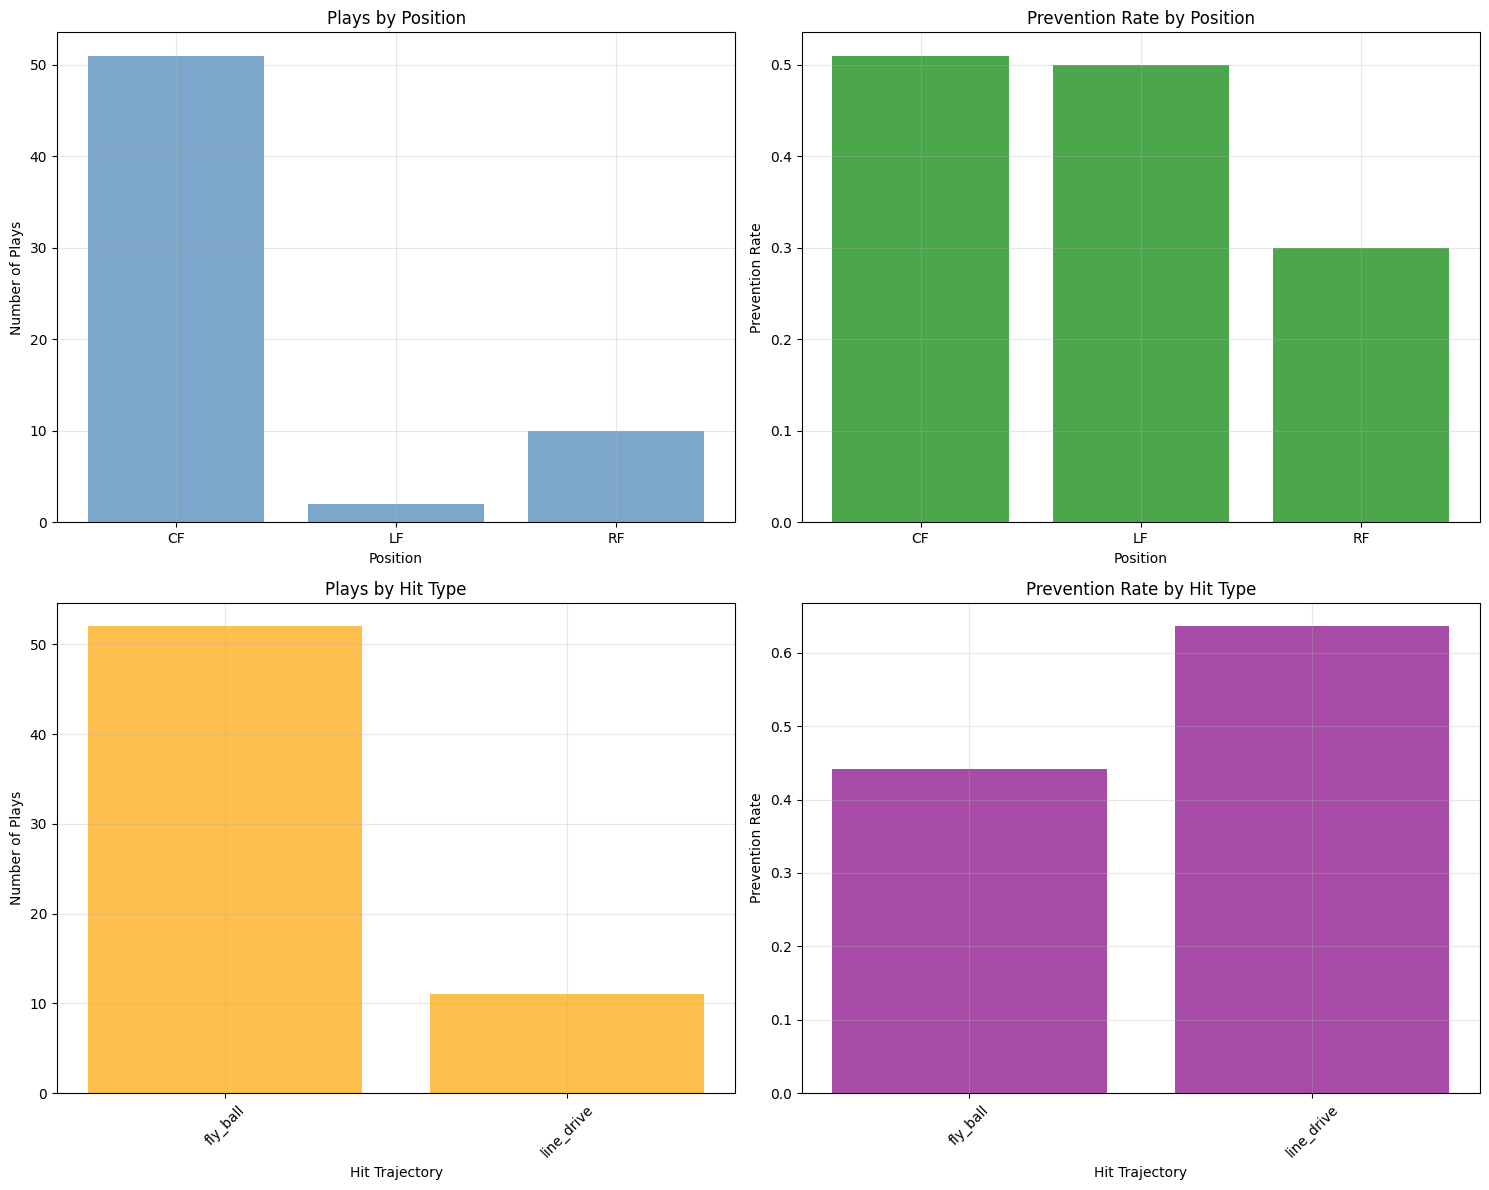

In [8]:
# Position breakdown with prevention frame
position_performance = fielder_train.groupby('fielder_pos').agg({
    'prevented': ['count', 'sum', 'mean'],
    'runner_advance': 'mean'  # Keep original for reference
}).round(3)

print(f"\n=== PERFORMANCE BY POSITION ===")
print("Prevention Rate by Position:")
print(position_performance)

# Hit trajectory breakdown
trajectory_performance = fielder_train.groupby('hit_trajectory').agg({
    'prevented': ['count', 'sum', 'mean'],
    'runner_advance': 'mean'  # Keep original for reference
}).round(3)

print(f"\n=== PERFORMANCE BY HIT TYPE ===")
print("Prevention Rate by Hit Type:")
print(trajectory_performance)

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Position performance
pos_counts = position_performance[('prevented', 'count')]
pos_rates = position_performance[('prevented', 'mean')]

ax1.bar(pos_counts.index, pos_counts.values, color='steelblue', alpha=0.7)
ax1.set_xlabel('Position')
ax1.set_ylabel('Number of Plays')
ax1.set_title('Plays by Position')
ax1.grid(True, alpha=0.3)

ax2.bar(pos_rates.index, pos_rates.values, color='green', alpha=0.7)
ax2.set_xlabel('Position')
ax2.set_ylabel('Prevention Rate')
ax2.set_title('Prevention Rate by Position')
ax2.grid(True, alpha=0.3)

# Hit trajectory performance
traj_counts = trajectory_performance[('prevented', 'count')]
traj_rates = trajectory_performance[('prevented', 'mean')]

ax3.bar(traj_counts.index, traj_counts.values, color='orange', alpha=0.7)
ax3.set_xlabel('Hit Trajectory')
ax3.set_ylabel('Number of Plays')
ax3.set_title('Plays by Hit Type')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

ax4.bar(traj_rates.index, traj_rates.values, color='purple', alpha=0.7)
ax4.set_xlabel('Hit Trajectory')
ax4.set_ylabel('Prevention Rate')
ax4.set_title('Prevention Rate by Hit Type')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Results Summary and Recommendations

This section provides a comprehensive summary of the analysis results and actionable recommendations for coaching staff.


In [9]:
# Generate comprehensive report
print("\n" + "="*60)
print("OUTFIELDER PERFORMANCE REPORT")
print("="*60)

print(f"\nEXECUTIVE SUMMARY")
print(f"Outfielder {target_fielder} has been involved in {len(fielder_train)} sacrifice play situations")
print(f"with a prevention rate of {prevention_rate:.1%} (prevented {prevention_rate*len(fielder_train):.0f} of {len(fielder_train)} advances).")

print(f"\nCONTEXTUAL PERFORMANCE ANALYSIS (n ≥ 10):")
if len(tbl) > 0:
    # Filter for decision-making contexts (n ≥ 10)
    decision_contexts = [p for p in tbl.to_dict('records') if p['n'] >= 10]
    if decision_contexts:
        # Sort by impact
        decision_contexts.sort(key=lambda x: x['impact'], reverse=True)
        for perf in decision_contexts:
            context = f"Base{perf['runner_base']}_Outs{perf['outs']}_{perf['depth_bin']}"
            print(f"• {context}: {perf['player_prevent']:.1%} vs {perf['league_prevent']:.1%} league average")
            print(f"  Difference: {perf['diff']:+.1%} (n={perf['n']}, CI: [{perf['ci_low']:.1%}, {perf['ci_high']:.1%}], impact: {perf['impact']:.2f})")
    else:
        print("• No contexts with sufficient sample size (n ≥ 10)")
else:
    print("• Insufficient sample size for contextual analysis")

print(f"\nKEY FINDINGS:")

# Throw speed analysis
if isinstance(throw_analysis, dict):
    print(f"• Throw Speed: {throw_analysis['winsorized_median']:.1f} mph median (~P{throw_analysis['league_percentile']*100:.0f} in league)")
    if throw_analysis['outliers_removed'] > 0:
        print(f"  - {throw_analysis['outliers_removed']} outliers removed (>{throw_analysis['p95']:.1f} mph)")
    print(f"  - Raw mean: {throw_analysis['mean']:.1f} mph, Median: {throw_analysis['median']:.1f} mph")
else:
    print(f"• Throw Speed: {throw_analysis}")

# Position performance
print(f"\n• Position Performance (Prevention Rate):")
for pos in position_performance.index:
    count = position_performance.loc[pos, ('prevented', 'count')]
    prevention_rate_pos = position_performance.loc[pos, ('prevented', 'mean')]
    print(f"  - {pos}: {count} plays, {prevention_rate_pos:.1%} prevention rate")

# Runs prevented
print(f"\n• Context-weighted Runs Prevented: {total_rp:.2f} runs")

print(f"\nRECOMMENDATIONS:")

# Contextual recommendations (focus on decision-making contexts)
if len(tbl) > 0:
    decision_contexts = [p for p in tbl.to_dict('records') if p['n'] >= 10]
    above_avg_contexts = [p for p in decision_contexts if p['diff'] > 0.05]
    below_avg_contexts = [p for p in decision_contexts if p['diff'] < -0.05]
    
    if above_avg_contexts:
        print(f"• STRENGTHS: Above average in {len(above_avg_contexts)} decision-making contexts")
        for ctx in sorted(above_avg_contexts, key=lambda x: x['impact'], reverse=True):
            context = f"Base{ctx['runner_base']}_Outs{ctx['outs']}_{ctx['depth_bin']}"
            print(f"  - {context}: +{ctx['diff']:.1%} vs league (impact: {ctx['impact']:.2f})")
    
    if below_avg_contexts:
        print(f"• AREAS FOR IMPROVEMENT: Below average in {len(below_avg_contexts)} decision-making contexts")
        for ctx in sorted(below_avg_contexts, key=lambda x: x['impact'], reverse=True):
            context = f"Base{ctx['runner_base']}_Outs{ctx['outs']}_{ctx['depth_bin']}"
            print(f"  - {context}: {ctx['diff']:.1%} vs league (impact: {ctx['impact']:.2f})")

# General recommendations
if prevention_rate > 0.6:
    print(f"• Strong overall prevention rate ({prevention_rate:.1%})")
    print(f"• Consider increased playing time in high-leverage situations")
elif prevention_rate < 0.4:
    print(f"• Below average prevention rate ({prevention_rate:.1%})")
    print(f"• Focus on positioning and throwing mechanics")
else:
    print(f"• Average prevention rate ({prevention_rate:.1%})")
    print(f"• Continue current development plan")

print(f"\nADDITIONAL CONSIDERATIONS:")
print(f"• Sample size of {len(fielder_train)} plays provides moderate confidence")
print(f"• Contextual analysis shows performance varies by situation")
print(f"• Estimated {total_rp:.1f} runs prevented demonstrates defensive value")



OUTFIELDER PERFORMANCE REPORT

EXECUTIVE SUMMARY
Outfielder 6HuoaRi0 has been involved in 63 sacrifice play situations
with a prevention rate of 47.6% (prevented 30 of 63 advances).

CONTEXTUAL PERFORMANCE ANALYSIS (n ≥ 10):
• Base3_Outs1_medium: 35.7% vs 12.1% league average
  Difference: +23.6% (n=14, CI: [16.3%, 61.2%], impact: 2.65)
• Base2_Outs1_medium: 76.5% vs 74.2% league average
  Difference: +2.3% (n=17, CI: [52.7%, 90.4%], impact: 0.10)

KEY FINDINGS:
• Throw Speed: 101.2 mph median (~P96 in league)
  - Raw mean: 100.6 mph, Median: 101.2 mph

• Position Performance (Prevention Rate):
  - CF: 51 plays, 51.0% prevention rate
  - LF: 2 plays, 50.0% prevention rate
  - RF: 10 plays, 30.0% prevention rate

• Context-weighted Runs Prevented: 3.05 runs

RECOMMENDATIONS:
• STRENGTHS: Above average in 1 decision-making contexts
  - Base3_Outs1_medium: +23.6% vs league (impact: 2.65)
• Average prevention rate (47.6%)
• Continue current development plan

ADDITIONAL CONSIDERATIONS:
• S